# Overview

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission File

For each `SK_ID_CURR` in the test set, you must predict a probability for the `TARGET` variable. The file should contain a header and have the following format:
```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

# Timeline

- August 22, 2018 - Entry deadline. You must accept the competition rules before this date in order to compete.
- August 22, 2018 - Team Merger deadline. This is the last day participants may join or merge teams.
- August 29, 2018 - Final submission deadline.

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Data Description

## application_{train|test}.csv
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

## bureau.csv
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

## bureau_balance.csv
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

## POS_CASH_balance.csv
- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

## credit_card_balance.csv
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

## previous_application.csv
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

## installments_payments.csv
- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

## HomeCredit_columns_description.csv
- This file contains descriptions for the columns in the various data files.

![alt text](home_credit.png)

In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [277]:
def cat_dist(column):
    ax = sns.countplot(column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    print(column.value_counts(dropna=False))
    
def transform_dataframe(df, labels, scaler=None):
    leave = df[labels.loc[labels['col_type']=='leave']['col_name']]
    dummy = df[labels.loc[labels['col_type']=='dum']['col_name']]
    normalize = df[labels.loc[labels['col_type']=='norm']['col_name']]
    
    leave = leave.fillna(-100000)
    normalize = normalize.fillna(-100000)
    
    dummy = pd.get_dummies(dummy, dummy_na=True, drop_first=True)
    
    if scaler==None:
        scaler = StandardScaler()
        normalize = scaler.fit_transform(normalize)
    else:
        normalize = scaler.transform(normalize)
        
    normalize = pd.DataFrame(normalize)
    
    X = pd.concat([leave, dummy, normalize], axis=1)
    
    y = df['TARGET']
    
    return X, y, scaler

In [269]:
application_train = pd.read_csv('application_train.csv')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


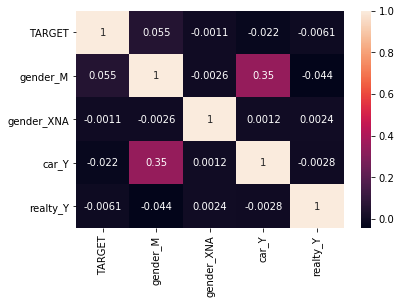

In [271]:
df = pd.DataFrame()
df['TARGET'] = application_train['TARGET']

df = pd.concat([df, pd.get_dummies(application_train['CODE_GENDER'], prefix='gender', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(application_train['FLAG_OWN_CAR'], prefix='car', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(application_train['FLAG_OWN_REALTY'], prefix='realty', drop_first=True)], axis=1)

sns.heatmap(df.corr(), annot=True)

In [232]:
col_names = application_train.iloc[:,62:].columns
# dum, norm, leave, del
col_type = ['leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave', 
            'leave',
            'dum',
            'dum',
            'leave',
            'dum',
            'dum',
            'norm',
            'norm',
            'norm',
            'norm',
            'norm',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'dum',
            'norm',
            'norm',
            'norm',
            'norm',
            'norm',
            'norm']
n_nan = application_train.iloc[:,62:].isnull().sum()

labels_df = pd.DataFrame([col_names, col_type, n_nan], index=['col_name', 'col_type', 'n_nan']).T

In [285]:
df = application_train.iloc[:,62:]
df['TARGET'] = application_train['TARGET']

X, y, _ = transform_dataframe(df, labels_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


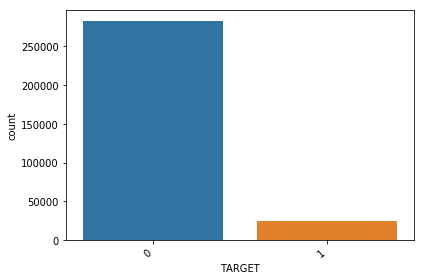

0    282686
1     24825
Name: TARGET, dtype: int64


In [198]:
cat_dist(application_train.TARGET)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


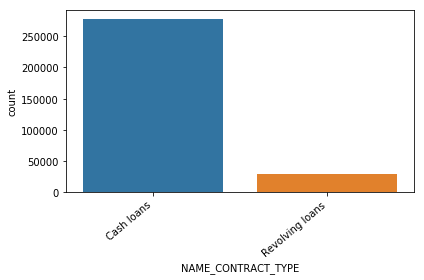

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


In [199]:
cat_dist(application_train.NAME_CONTRACT_TYPE)

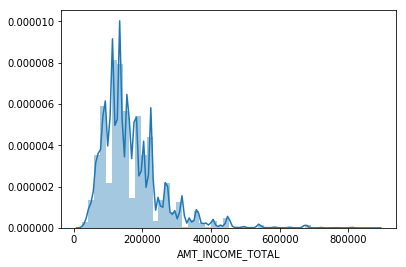

In [156]:
S = application_train.AMT_INCOME_TOTAL
S = S[np.abs(S-S.mean())<=(3*S.std())]
sns.distplot(S)

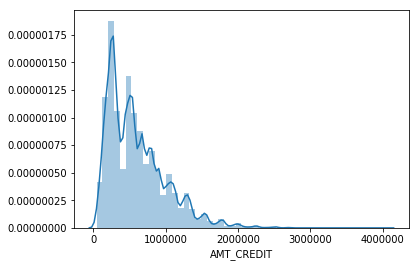

In [151]:
S = application_train.AMT_CREDIT
#S = S[np.abs(S-S.mean())<=(3*S.std())]
sns.distplot(S)

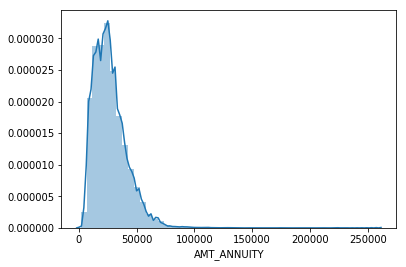

In [150]:
S = application_train.AMT_ANNUITY.dropna()
#S = S[np.abs(S-S.mean())<=(3*S.std())]
sns.distplot(S)

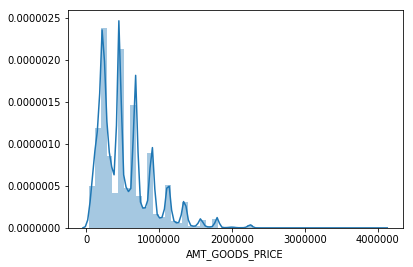

In [154]:
S = application_train.AMT_GOODS_PRICE.dropna()
#S = S[np.abs(S-S.mean())<=(3*S.std())]
sns.distplot(S)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


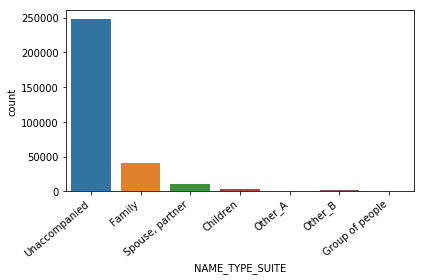

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64


In [194]:
cat_dist(application_train.NAME_TYPE_SUITE)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


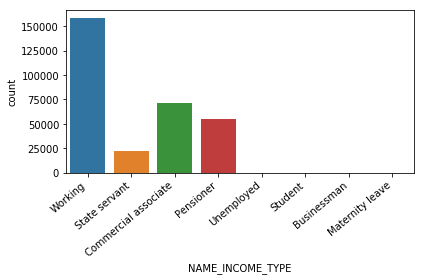

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64


In [195]:
cat_dist(application_train.NAME_INCOME_TYPE)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


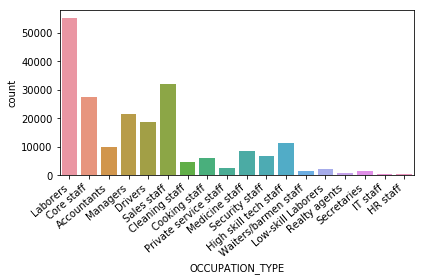

NaN                      96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64


In [196]:
cat_dist(application_train.OCCUPATION_TYPE)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


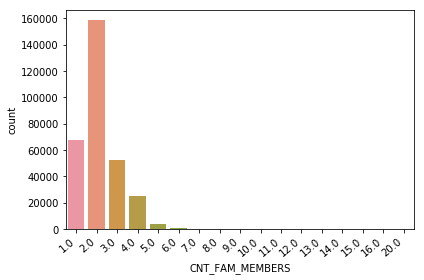

 2.0     158357
 1.0      67847
 3.0      52601
 4.0      24697
 5.0       3478
 6.0        408
 7.0         81
 8.0         20
 9.0          6
 10.0         3
 14.0         2
 16.0         2
 12.0         2
NaN           2
 20.0         2
 11.0         1
 13.0         1
 15.0         1
Name: CNT_FAM_MEMBERS, dtype: int64


In [197]:
cat_dist(application_train.CNT_FAM_MEMBERS)

/Users/lukasolson/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


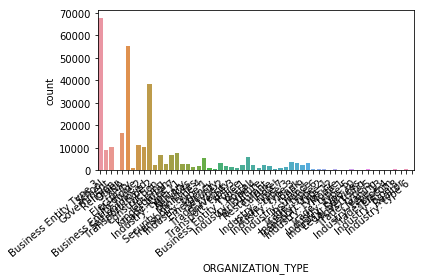

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [201]:
cat_dist(application_train.ORGANIZATION_TYPE)

In [5]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [12]:
installments_payments = pd.read_csv('installments_payments.csv')
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [14]:
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [15]:
previous_application = pd.read_csv('previous_application.csv')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
